Importando as bibliotecas necessárias

In [1]:
import logging
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from numpy import isin

SEED = 42
np.random.seed(SEED)

Criando um modelo Word2Vec com técnica skipgram

Carregando o spaCy para dentro da variável `nlp` que vai ser usada para o pré processamento

É possível desativar alguns módulos para melhorar o desempenho do treinamento mas neste caso vou tentar extrair o máximo de informação.

In [2]:
# nlp = spacy.load("pt_core_news_sm", disable=["paser", "ner", "tagger", "textcat"])
nlp = spacy.load("pt_core_news_sm")

Lendo as duas bases de dados e conferindo seus tamanhos sem nenhum tratamento.

In [3]:
news_caliman = pd.read_csv('datasets/kaggle_diogo_caliman_historico_materias.csv')
news_marlesson = pd.read_csv('datasets/kaggle_marlesson_noticias_folha_sp.csv')

print('sem drop de NaN: ', news_caliman.shape)
print('sem drop de NaN: ', news_marlesson.shape)

sem drop de NaN:  (10109, 6)
sem drop de NaN:  (167053, 6)


Tendo duas abordagens diferentes para testar resultados, na menor, removendo os dados que não possuem nada e na segunda, preenchendo eles com `stopwords`, depois verificando o tamanho que os dataframes ficaram.

In [4]:
news_caliman.dropna(inplace=True)
news_marlesson.fillna('e mas até', inplace=True)

print('com drop de NaN: ', news_caliman.shape)
print('com drop de NaN: ', news_marlesson.shape)

com drop de NaN:  (10099, 6)
com drop de NaN:  (167053, 6)


Verificando a quantidade de conteúdo por assunto no menor dataset.

In [5]:
news_caliman.assunto.value_counts()

esportes      6026
economia      1558
politica      1363
tecnologia     612
famosos        540
Name: assunto, dtype: int64

Fazendo uma análise de interesse é notável que o tema esporte não é muito útil para este caso, então removo-o.

In [6]:
news_caliman.drop(news_caliman[news_caliman['assunto'] == 'esportes'].index, inplace=True)

Revendo agora a quantidade de dados que nós temos e fica muito mais enxuto.

In [7]:
news_caliman.assunto.value_counts()

economia      1558
politica      1363
tecnologia     612
famosos        540
Name: assunto, dtype: int64

Criando uma função para limpar os dados junto ao nosso `nlp`, onde varremos cada `doc` e verificamos se não é uma `stopword` e se é `alphabetic`.

In [8]:
def clean_text(doc):
    result = ""

    for token in doc:
        is_valid = not token.is_stop and token.is_alpha

        if is_valid:
            result += f"{token} "

    return result.rstrip()

Inserindo os tamanhos de cada notícias para dentro do dataframe

In [9]:
news_caliman['tamanho_noticia'] = news_caliman.conteudo_noticia.str.len()

Conferindo a média e máxima dos tamanhos de textos

In [10]:
print(news_caliman['tamanho_noticia'].mean(), news_caliman['tamanho_noticia'].max());

3081.8219985268843 32851


# Separando as notícias por quantidade de caracteres.
large > 10000  
short < 3001  
medium >= 3001 e <= 6000  
medium_large >= 6001 e <= 10000

In [11]:
news_caliman.sort_values(by=['assunto', 'tamanho_noticia'], ascending=True, inplace=True);

In [12]:
def set_size(size):
    if(size <= 3000): return 'short'
    elif (size <= 6000): return 'medium'
    else: return 'large'

In [13]:
news_caliman['tamanho'] = news_caliman['tamanho_noticia'].map(set_size)

In [14]:
news_splited = np.array_split(news_caliman, 8)

# Inserindo a *tag* de tamanho para cada tipo de texto

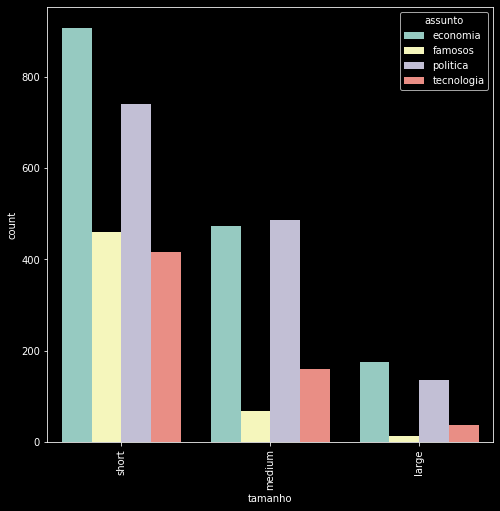

In [15]:
plt.figure(figsize=(8,8))
plt.xticks(rotation=90)
sns.countplot(x='tamanho', hue='assunto',data = news_caliman)
plt.show()


# Processando as notícias para limpar o texto

In [16]:
for news in news_splited:
    news_to_clean = (news.lower() for news in news["conteudo_noticia"])

In [17]:
news_cleaned = [clean_text(doc) for doc in nlp.pipe(news_to_clean,  batch_size = 10000, n_process = -1)]

In [18]:
news_to_list = pd.DataFrame({'news': news_cleaned})
news_to_list.drop_duplicates(inplace=True)

In [19]:
news_list = [news.split(' ') for news in news_to_list.news]

In [33]:
def train_model(sg, window, vector_size, path):
    logging.basicConfig(format='%(asctime)s : - %(message)s', level=logging.INFO)

    model = Word2Vec(sg = sg, window = window, min_count = 5, vector_size = vector_size, alpha = 0.03, min_alpha=0.007)
    model.build_vocab(news_list, progress_per=5000)
    model.train(news_list, total_examples = model.corpus_count, epochs = 1000)
    model.wv.save_word2vec_format(path, binary=False)

O primeiro bloco de treinamento foi feito com os seguintes parâmetros e está salvo em `/models/xx/`

sg = 1, window = 4, min_count = 5, vector_size = 300/600/1000, alpha = 0.03, min_alpha=0.007

## Window 5

In [45]:
train_model(sg=1, window=5, vector_size=300, path='models/caliman/sg/5/300.txt')
train_model(sg=1, window=5, vector_size=600, path='models/caliman/sg/5/600.txt')
train_model(sg=1, window=5, vector_size=1000, path='models/caliman/sg/5/1000.txt')

2022-11-17 17:42:55,249 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-17T17:42:55.249878', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 17:42:55,251 : - collecting all words and their counts
2022-11-17 17:42:55,252 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 17:42:55,267 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 17:42:55,268 : - Creating a fresh vocabulary
2022-11-17 17:42:55,285 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T17:42:55.285426', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

## Window 50

O Segundo bloco de treinamento tem como objetivo aumentar o parâmetro `window` e será salvo em `models/xx/v2` quando estamos falando de um valor de 50 para o `window`

In [46]:
train_model(sg=1, window=50, vector_size=300, path='models/caliman/sg/50/300.txt')

2022-11-17 18:04:48,973 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-17T18:04:48.973358', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 18:04:48,975 : - collecting all words and their counts
2022-11-17 18:04:48,976 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 18:04:48,993 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 18:04:48,994 : - Creating a fresh vocabulary
2022-11-17 18:04:49,011 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T18:04:49.011144', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [47]:
train_model(sg=1, window=50, vector_size=600, path='models/caliman/sg/50/600.txt')

2022-11-17 18:37:50,715 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=600, alpha=0.03>', 'datetime': '2022-11-17T18:37:50.715945', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 18:37:50,718 : - collecting all words and their counts
2022-11-17 18:37:50,718 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 18:37:50,734 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 18:37:50,735 : - Creating a fresh vocabulary
2022-11-17 18:37:50,751 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T18:37:50.751503', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [48]:
train_model(sg=1, window=50, vector_size=1000, path='models/caliman/sg/50/1000.txt')

2022-11-17 19:34:26,796 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=1000, alpha=0.03>', 'datetime': '2022-11-17T19:34:26.796939', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 19:34:26,798 : - collecting all words and their counts
2022-11-17 19:34:26,800 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 19:34:26,820 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 19:34:26,821 : - Creating a fresh vocabulary
2022-11-17 19:34:26,839 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T19:34:26.839869', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standa

## Window 100

In [49]:
train_model(sg=1, window=100, vector_size=300, path='models/caliman/sg/100/300.txt')

2022-11-17 21:00:00,629 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-17T21:00:00.629597', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 21:00:00,630 : - collecting all words and their counts
2022-11-17 21:00:00,631 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 21:00:00,648 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 21:00:00,649 : - Creating a fresh vocabulary
2022-11-17 21:00:00,672 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T21:00:00.672147', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [50]:
train_model(sg=1, window=100, vector_size=600, path='models/caliman/sg/100/600.txt')

2022-11-17 21:59:32,060 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=600, alpha=0.03>', 'datetime': '2022-11-17T21:59:32.060859', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 21:59:32,062 : - collecting all words and their counts
2022-11-17 21:59:32,062 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 21:59:32,079 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 21:59:32,080 : - Creating a fresh vocabulary
2022-11-17 21:59:32,096 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T21:59:32.096928', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [51]:
train_model(sg=1, window=100, vector_size=1000, path='models/caliman/sg/100/600.txt')

2022-11-18 00:55:22,642 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=1000, alpha=0.03>', 'datetime': '2022-11-18T00:55:22.642179', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-18 00:55:22,644 : - collecting all words and their counts
2022-11-18 00:55:22,645 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-18 00:55:22,693 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-18 00:55:22,695 : - Creating a fresh vocabulary
2022-11-18 00:55:22,737 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-18T00:55:22.737342', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standa

# CBOW


## Window 5

In [41]:
train_model(sg=0, window=5, vector_size=300, path='models/caliman/cbow/5/300.txt')

2022-11-17 17:28:25,915 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-17T17:28:25.915568', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 17:28:25,917 : - collecting all words and their counts
2022-11-17 17:28:25,918 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 17:28:25,937 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 17:28:25,938 : - Creating a fresh vocabulary
2022-11-17 17:28:25,960 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T17:28:25.960763', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [42]:
train_model(sg=0, window=5, vector_size=600, path='models/caliman/cbow/5/600.txt')

2022-11-17 17:29:38,001 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=600, alpha=0.03>', 'datetime': '2022-11-17T17:29:38.001564', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 17:29:38,003 : - collecting all words and their counts
2022-11-17 17:29:38,004 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 17:29:38,019 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 17:29:38,020 : - Creating a fresh vocabulary
2022-11-17 17:29:38,037 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T17:29:38.037094', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [43]:
train_model(sg=0, window=5, vector_size=1000, path='models/caliman/cbow/5/1000.txt')

2022-11-17 17:31:32,234 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=1000, alpha=0.03>', 'datetime': '2022-11-17T17:31:32.234588', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 17:31:32,236 : - collecting all words and their counts
2022-11-17 17:31:32,237 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 17:31:32,258 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 17:31:32,258 : - Creating a fresh vocabulary
2022-11-17 17:31:32,279 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T17:31:32.279038', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standa

## Window 50

In [52]:
train_model(sg=0, window=50, vector_size=300, path='models/caliman/cbow/50/300.txt')

2022-11-18 05:41:12,942 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-18T05:41:12.942701', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-18 05:41:12,944 : - collecting all words and their counts
2022-11-18 05:41:12,945 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-18 05:41:12,980 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-18 05:41:12,982 : - Creating a fresh vocabulary
2022-11-18 05:41:13,008 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-18T05:41:13.008240', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [53]:
train_model(sg=0, window=50, vector_size=600, path='models/caliman/cbow/50/600.txt')

2022-11-18 05:46:11,880 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=600, alpha=0.03>', 'datetime': '2022-11-18T05:46:11.880635', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-18 05:46:11,883 : - collecting all words and their counts
2022-11-18 05:46:11,885 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-18 05:46:11,931 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-18 05:46:11,937 : - Creating a fresh vocabulary
2022-11-18 05:46:11,969 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-18T05:46:11.969503', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [54]:
train_model(sg=0, window=50, vector_size=1000, path='models/caliman/cbow/50/1000.txt')

2022-11-18 05:53:21,989 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=1000, alpha=0.03>', 'datetime': '2022-11-18T05:53:21.989151', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-18 05:53:21,991 : - collecting all words and their counts
2022-11-18 05:53:21,992 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-18 05:53:22,025 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-18 05:53:22,026 : - Creating a fresh vocabulary
2022-11-18 05:53:22,050 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-18T05:53:22.050327', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standa

## Window 100

In [55]:
train_model(sg=0, window=100, vector_size=300, path='models/caliman/cbow/100/300.txt')

2022-11-18 06:04:16,627 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-18T06:04:16.627637', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-18 06:04:16,628 : - collecting all words and their counts
2022-11-18 06:04:16,629 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-18 06:04:16,650 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-18 06:04:16,651 : - Creating a fresh vocabulary
2022-11-18 06:04:16,673 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-18T06:04:16.673125', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [44]:
train_model(sg=0, window=100, vector_size=600, path='models/caliman/cbow/100/600.txt')

2022-11-17 17:34:08,962 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=600, alpha=0.03>', 'datetime': '2022-11-17T17:34:08.962876', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-17 17:34:08,964 : - collecting all words and their counts
2022-11-17 17:34:08,966 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-17 17:34:08,984 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-17 17:34:08,985 : - Creating a fresh vocabulary
2022-11-17 17:34:09,000 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-17T17:34:09.000857', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standar

In [56]:
train_model(sg=0, window=100, vector_size=1000, path='models/caliman/cbow/100/1000.txt')

2022-11-18 06:11:20,344 : - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=1000, alpha=0.03>', 'datetime': '2022-11-18T06:11:20.344583', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standard-WSL2-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2022-11-18 06:11:20,346 : - collecting all words and their counts
2022-11-18 06:11:20,347 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-18 06:11:20,362 : - collected 16937 word types from a corpus of 123094 raw words and 508 sentences
2022-11-18 06:11:20,363 : - Creating a fresh vocabulary
2022-11-18 06:11:20,380 : - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4380 unique words (25.86% of original 16937, drops 12557)', 'datetime': '2022-11-18T06:11:20.380560', 'gensim': '4.2.0', 'python': '3.7.13 (default, Oct 18 2022, 18:57:03) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.74.2-microsoft-standa

10k Épocas se mostrou tão ruim quanto muito poucas épocas

In [57]:
# logging.basicConfig(format='%(asctime)s : - %(message)s', level=logging.INFO)

# model = Word2Vec(sg = 1, window = 15, min_count = 5, vector_size = 300, alpha = 0.03, min_alpha=0.007, compute_loss=True)
# model.build_vocab(news_list, progress_per=5000)
# model.train(news_list, total_examples = model.corpus_count, epochs = 10000)
# model.wv.save_word2vec_format('models/tests/caliman/sg_300_epochs_10k.txt', binary=False)

In [58]:
# model.wv.most_similar(positive=['negro'])

In [59]:
# model.wv.most_similar(positive=['negro'])

In [60]:
# model.wv.most_similar(positive=['jovem'])